In [2]:
import os 
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import colorsys
from PIL import Image,ImageEnhance

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib notebook

In [3]:
# store the image in list
files_apples = glob.glob("apples/*.jpg")

filesMask = glob.glob("apples/*.png")

trainApple = []
trainMask = []

for cFile in files_apples:
    im = plt.imread(cFile)
    trainApple.append(im)
for cFile in filesMask:
    im = plt.imread(cFile)
    trainMask.append(im)

# Display one train image and generate training data

Text(0.5,1,'groundtruth')

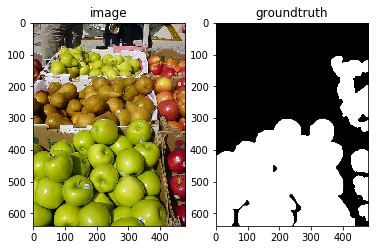

In [4]:
# Only display one of the trainning samples to demonstrate what should the ground truth looks like
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(trainApple[0])
ax1.set_title('image')
ax2.imshow(trainMask[0])
ax2.set_title('groundtruth')

#f,(ax1,ax2) = plt.subplots(1,2)
# ax1.imshow(trainApple[1])
# ax1.set_title('image')
# ax2.imshow(trainMask[1])
# ax2.set_title('groundtruth')

In [5]:
# Convert the picture into a matrix so as to get the trainning dataset RGBApple and RGBNonApple
# Create the training data set.(because we dont know how many pixels we may have, so initialize the trainning set to be 
# a one million long vector.
RGBApple_initial = np.zeros((3,1000000)) 
RGBNonApple_initial = np.zeros((3,1000000))
cApple = 0  # use this variable to count the number of apple pixels
cNonapple = 0  # use this variable to count the number of non apple pixels
print('Generating the traing data set...')
for cImage in range(len(trainApple)):
    image = np.array(trainApple[cImage])
    mask = np.array(trainMask[cImage])
    row,col,channel = image.shape
    for cRow in range(row):
        for cCol in range(col):
            if (mask[cRow,cCol][1]==1):
                RGBApple_initial[:,cApple] = image[cRow,cCol,:]
                cApple += 1
            else:
                # print(image[cRow,cCol].shape,RGBNonApple[:,cNonapple].shape)
                RGBNonApple_initial[:,cNonapple] = image[cRow,cCol,:]
                cNonapple += 1
# Transpose the trainning data set to shuffle them
RGBApple_full = np.float32(RGBApple_initial[:,0:cApple]).T
RGBNonApple_full = np.float32(RGBNonApple_initial[:,0:cNonapple]).T

np.random.shuffle(RGBApple_full)
np.random.shuffle(RGBNonApple_full)

RGBApple_full = RGBApple_full.T
RGBNonApple_full = RGBNonApple_full.T
print('Training data set Generated')

Generating the traing data set...
Training data set Generated


In [6]:
print(cApple,cNonapple)

424647 375653


# The Training phase

In [7]:
# Calculate the multivariate_normal's probablity. 
# This self defined function is 66% quicker than the build-in Function'multivariate_normal.pdf()'
def CalMulGaussProb(thisData,curMean,curCov):
    nDims, = thisData.shape
    denominant  = ((2 * np.pi)**(nDims/2) * np.linalg.det(curCov)**0.5)
    GaussProb = np.exp(-0.5 * np.transpose(thisData - curMean)@ np.linalg.inv(curCov)@(thisData - curMean))/denominant
    return GaussProb

In [8]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Notice!!!!!!!!!
    This function is the same as the [getMixGaussLogLike] function in practicalMixGauss_C. 
    reference : Machine Vision Lab2--practicalMixGauss_C
    
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]    
        # calculate likelihood of this data point under mixture of                         
        # Gaussians model.
        # initialize log likelihoods                                                                       
        like = 0
        # Gaussians model.                                                             
        for k in range(mixGaussEst['k']):
            curCov = mixGaussEst['cov'][:,:,k]

            curWeight = mixGaussEst['weight'][k]
            curMean = mixGaussEst['mean'][:,k]

            # Get the probability of Multivatiate normal distribution using the following function
            # denominant  = ((2 * np.pi)**(nDims/2) * np.linalg.det(curCov)**0.5)
            # GaussProb = np.exp(-0.5 * np.transpose(thisData - curMean)@ np.linalg.inv(curCov)
            #                  @(thisData - curMean))/denominant
            GaussProb = CalMulGaussProb(thisData,curMean,curCov)

            like = like + curWeight * GaussProb 
        # add to total log like
        logLike = logLike + np.log(like)                                                                                                                                                          
    return  np.asscalar(logLike)                                                                       
                                                                                                       

In [9]:
def fitMixGauss(data, k):
    """
    Notice!!!!!!!!!
    This function is an improved version of the [fitMixGauss] function in practicalMixGauss_C. 
    reference : Machine Vision Lab2--practicalMixGauss_C
    
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 0.5 * np.random.randn(nDims, k)+0.5
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood    
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 100 # Use 100 iteration to make sure the EM algorithm will converge.
    # will break if the converge condition is satisfied.
    print('Training the data...Entering the iteration')
    # logLikeVec = np.zeros(shape=(2 * nIter))
    pre_logLike = logLike
    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        # TC added these four line of codes
        GaussProb_M = np.zeros(k)
        mean = mixGaussEst['mean']
        cov = mixGaussEst['cov']
        curWeight = mixGaussEst['weight']
        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            
            thisData = data[:,cData]
            
            # Get the probability of Multivatiate normal distribution
            for h in range(k):
                curMean = mixGaussEst['mean'][:,h] # d by 1 vector
                curCov = mixGaussEst['cov'][:,:,h] 
                
                # GaussProb = multivariate_normal.pdf(thisData,curMean,curCov)
                GaussProb = CalMulGaussProb(thisData,curMean,curCov)
                GaussProb_M[h] = GaussProb # store the probability for each gaussian into a matrix
            p_denominant = np.sum(curWeight * GaussProb_M) # GaussProb_M is a （3，）vector
            postHidden[:, cData] = GaussProb_M * curWeight/p_denominant

            # postHidden[:, cData] = 1/k
            
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. 
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian. 
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss,:] * data,1)\
            /np.sum(postHidden[cGauss,:])

            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            Mean_cGauss = np.reshape(mixGaussEst['mean'][:,cGauss],newshape=(nDims,1)) 

            mixGaussEst['cov'][:,:,cGauss] =  (data- Mean_cGauss)\
            @ np.diag(postHidden[cGauss,:]) @ np.transpose(data - Mean_cGauss)/np.sum(postHidden[cGauss,:])
            
        current_logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, current_logLike))
        # Set the converge condition. If the current log like and the previous loglike satisfy this condition,
        # we can consider the EM algorithm has converged and then break the loop
        if np.absolute(current_logLike - pre_logLike) < 0.05 :
            break
        else:
            pre_logLike = current_logLike
            
    print('training finished')
    return mixGaussEst

In [10]:
# Number of Gaussian used to generate the MOG.According to our previous knowledge, 
# apple can be basically divided into two groups:Red apple and Green apple.So the MOG of should contain two gaussian component.
# one refers to red apple group and the other refer to green apple group.
CGauss =2
start_time = time.time()
# fit Gaussian model for apple data 
# IMPORTANT!!!!!!!!
# I downsample both the training data set for apple and Nonapple to be 10000 points so as to improve the trainning efficiency.
# because the trainning set has been shuffled before, these 10000 points are randomly from three sample images.
RGBApple =  RGBApple_full[:,0:10000]
RGBNonApple = RGBNonApple_full[:,0:10000]
print('start to train the apple')

# for Python training data set
# Normalize the RGB value to be in range [0,1].
mixGaussApple = fitMixGauss(RGBApple/255,CGauss)

print('mixGaussApple',mixGaussApple)

#fit Gaussian model for non-apple data
print('start to train the nonapple')
# for Python training data set
# After vissualizing the Non-apple training data set, the color can be basically diveded into yellow, black , white and other.
# So used 3 gaussian component.
mixGaussNonApple = fitMixGauss(RGBNonApple/255,CGauss + 1 )

print('mixGaussNonApple',mixGaussNonApple)
elapsed =  time.time()-start_time
print('The whole trainning phase takes',elapsed,'seconds')

start to train the apple
Log Likelihood Iter 0 : -43211.048

Training the data...Entering the iteration
Log Likelihood After Iter 0 : 6652.581

Log Likelihood After Iter 1 : 6808.068

Log Likelihood After Iter 2 : 7243.049

Log Likelihood After Iter 3 : 7987.774

Log Likelihood After Iter 4 : 8820.392

Log Likelihood After Iter 5 : 9565.598

Log Likelihood After Iter 6 : 10073.845

Log Likelihood After Iter 7 : 10374.530

Log Likelihood After Iter 8 : 10733.363

Log Likelihood After Iter 9 : 11222.003

Log Likelihood After Iter 10 : 11590.605

Log Likelihood After Iter 11 : 11748.906

Log Likelihood After Iter 12 : 11844.442

Log Likelihood After Iter 13 : 11933.258

Log Likelihood After Iter 14 : 12028.621

Log Likelihood After Iter 15 : 12139.271

Log Likelihood After Iter 16 : 12253.484

Log Likelihood After Iter 17 : 12357.210

Log Likelihood After Iter 18 : 12462.384

Log Likelihood After Iter 19 : 12566.126

Log Likelihood After Iter 20 : 12660.326

Log Likelihood After Iter 21 :

# The inference phase.  Use the given three test images

In [11]:
# store the test image in list
testApple = []
Mytest = []
testMask = []
Mymask = []

im = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg')
testApple.append(im)

im = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
testMask.append(im)

im = plt.imread('testApples/audioworm-QKUJj2wmxuI-original.jpg')
testApple.append(im)

im = plt.imread('testApples/Apples_by_MSR_MikeRyan_flickr.jpg')
testApple.append(im)


im = plt.imread('mytest/1.jpg')
Mytest.append(im)
im = plt.imread('mytest/2.jpg')
Mytest.append(im)

im = plt.imread('mymask/1.png')
Mymask.append(im)
im = plt.imread('mymask/2.png')
Mymask.append(im)

In [12]:
# The inference phase.Use this function to calculate the posteriorA
def Getposterior(im,mixGaussApple,mixGaussNonApple):
    print(im.shape)
    imY, imX, imZ = im.shape
    posteriorA = np.zeros([imY,imX])
    posteriorNonA = np.zeros([imY,imX])

    # get the mean and 
    Applemean = mixGaussApple['mean']
    Nonmean = mixGaussNonApple['mean']
    Applecov = mixGaussApple['cov']
    Noncov = mixGaussNonApple['cov']
    for cY in range(imY): 
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(im[cY,cX,:])/255 # normalized
            # thisPixelData = thisPixelData[:, np.newaxis]

            #make sure you've filled in calcGaussianProb above.
            likeA = 0
            likeNonA = 0
            #calculate likelihood of this data given apple model
            for k in range(mixGaussApple['k']):
                likeA = likeA + CalMulGaussProb(thisPixelData,Applemean[:,k],Applecov[:,:,k])*mixGaussApple['weight'][k]

                #calculate likelihood of this data given non apple model
            for k in range(mixGaussNonApple['k']):
                likeNonA = likeNonA + CalMulGaussProb(thisPixelData,Nonmean[:,k],Noncov[:,:,k]) * mixGaussNonApple['weight'][k]

            #TO DO (c):  calculate posterior probability from likelihoods and 
            #priors using BAYES rule. Replace this:
            evidence = likeA * priorA + likeNonA * priorNonA
            posteriorA[cY,cX]=likeA * priorA / evidence
            posteriorNonA[cY,cX]=likeNonA * priorA / evidence
    return posteriorA,posteriorNonA

In [13]:
# Calculating the posterior for all the three testApple images.
priorA = cApple/(cNonapple + cApple)
priorNonA = cNonapple/(cNonapple + cApple)

# now run through the pixels in the image and classify them as being apple or
# non apple
postAlist = []
postNAlist = []
for cimage in range(len(testApple)):
    print('Start to predict the NO.',cimage + 1,'image in the testSet')
    im = testApple[cimage]
    posteriorA,posteriorNonA = Getposterior(im,mixGaussApple,mixGaussNonApple)
    postAlist.append(posteriorA)
    postNAlist.append(posteriorNonA)
    print('The',cimage+1,'image inference phase has finished !!!')

Start to predict the NO. 1 image in the testSet
(1500, 2000, 3)
The 1 image inference phase has finished !!!
Start to predict the NO. 2 image in the testSet
(1080, 1620, 3)
The 2 image inference phase has finished !!!
Start to predict the NO. 3 image in the testSet
(435, 640, 3)
The 3 image inference phase has finished !!!


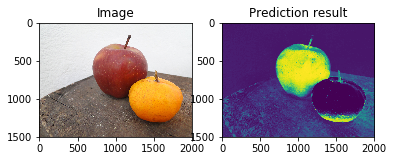

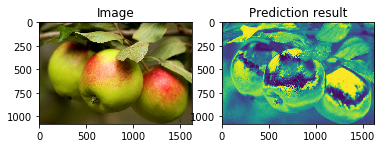

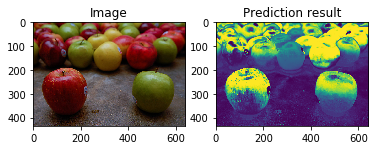

In [19]:
# plot the inference result against the ground true image for all the three testApple images.
for cimage in range(len(testApple)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    #show the image
    ax1.imshow(testApple[cimage])
    ax1.set_title('Image')
    #show the prediction result
    ax2.imshow(postAlist[cimage])
    ax2.set_title('Prediction result')

# Comments on the outcome :
For the first image the result looks relatively good because the occasion is simple and the RGB values of the desk is totally different from  an apple. However, some parts of the orange are wrongly identified as apple because the the shadow part(the dark orange color on the bottom orange) is similar to red.

For the second image , my model wrongly detect the leaf to be apple because in our training data, we dont have sufficient green objects in Non-Apple set so most of the green pixels will be consider as green apple confidently by my model.The dark area of the apple will be consider less likely to be an apple because the RGB intensity change alot when light intensity change.The boundary between red part and green part is yellow, so my model wrongly consider most the yellow part to be non-apple. 

For the Thrid one, the dark part of the Apple are identified bedly because in training data set,we dont have enough dark apple training samples and the RGB values are sensitive to light intensity.

Text(0.5,1,'Prediction result')

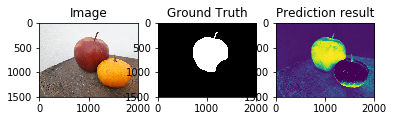

In [193]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
#show the image
ax1.imshow(testApple[0])
ax1.set_title('Image')
#show the ground truth mask
ax2.imshow(testMask[0])
ax2.set_title('Ground Truth')
#show our prediction!
ax3.imshow(postAlist[0])
ax3.set_title('Prediction result')

# Draw the ROC curve!

In [180]:
# get the point on ROC curve given a threshold
def getROCpoint(mask,prediction,threshold):   
    imY,imX,channel= mask.shape
    # initialize the True positive(TP),True Negative(TN),
    # False positive(FP),False Negative(FN)
    TP = TN = FP = FN = 0 
    predictMask = np.zeros([imY,imX])
    for row in range(imY):
        for col in range(imX):
            if prediction[row,col] > threshold:
                predictMask[row,col] = 1
            else:
                predictMask[row,col] = 0
            if mask[row,col,1] == 1 and predictMask[row,col]== 1:
                TP += 1
            elif mask[row,col,1] == 1 and predictMask[row,col]== 0:
                FN += 1
            elif mask[row,col,1] == 0 and predictMask[row,col]== 0:
                TN += 1
            elif mask[row,col,1] == 0 and predictMask[row,col]== 1:
                FP += 1
    FPR = FP/(FP + TN)
    TPR = TP/(TP + FN)
    return FPR,TPR

In [184]:
# return the FPR matrix and TRP matrix
def drawROC(mask,prediction,k):
    threshold = np.linspace(0,1,k)
    FPR_M = np.zeros(k)
    TPR_M = np.zeros(k)
    for cPoint in range(k):
        FPR,TPR = getROCpoint(mask,prediction,threshold[cPoint])
        FPR_M[cPoint] = FPR
        TPR_M[cPoint] = TPR
    return FPR_M,TPR_M

In [197]:
# Cauculate the FPR and TPR of the ROC curve for test image
FPR_M,TPR_M = drawROC(testMask[0],postAlist[0],11)

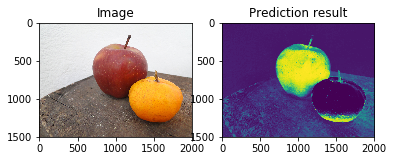

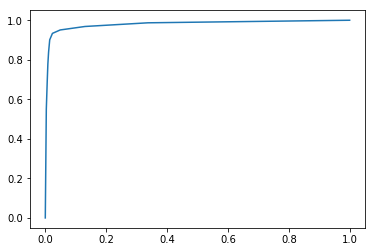

In [198]:
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(testApple[0])
ax1.set_title('Image')
ax2.imshow(postAlist[0])
ax2.set_title('Prediction result')
plt.figure()
plt.plot(FPR_M,TPR_M )

## How to get the best performance of the model (taught by image processing)
If the ROC curve is closer to the left_top corner, the model performance is considered to be better.we calculate the Square distance from the curve the left top corner so as to find a perticular threshold that can make this model perform best.

In [222]:
# Find the best threshold so as the get the true positive rate and the true negative rate
distance = (FPR_M - 0)**2 + (TPR_M - 1)**2
min_distance = np.min(distance)
# return the index that make the distance minimum
BestT = np.where(distance == min_distance)
Best_threshold = 0.1 * (BestT[0][0]-1)
print('The Best threshold is :',Best_threshold)
TNR = 1 - FPR_M[BestT[0]]
print('The true negative rate under this threhold is ',TNR)
print('The true positive rate under this threhold is ',TPR_M[BestT[0]])

The Best threshold is : 0.2
The true negative rate under this threhold is  [0.9510718]
The true positive rate under this threhold is  [0.95082061]


#  Comment:
From the ROC curve, we can see the this model is actually a good model with over 95% accuracy in this case.We can say this model is good at dealing with simple identification tasks such as identifify a single apple from background which doesnt have similar color to apple.

In [199]:
# Calculating the posterior for all the three testApple images.
priorA = cApple/(cNonapple + cApple)
priorNonA = cNonapple/(cNonapple + cApple)

# now run through the pixels in the image and classify them as being apple or
# non apple
mypostAlist = []
mypostNAlist = []
for cimage in range(len(Mytest)):
    print('Start to predict the NO.',cimage + 1,'image in the testSet')
    im = Mytest[cimage]
    posteriorA,posteriorNonA = Getposterior(im,mixGaussApple,mixGaussNonApple)
    mypostAlist.append(posteriorA)
    mypostNAlist.append(posteriorNonA)
    print('The',cimage+1,'image inference phase has finished ')

Start to predict the NO. 1 image in the testSet
(853, 1280, 3)
The 1 image inference phase has finished 
Start to predict the NO. 2 image in the testSet
(1024, 768, 3)
The 2 image inference phase has finished 


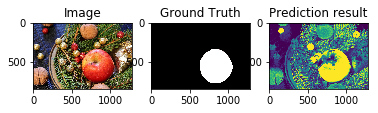

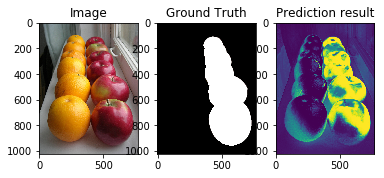

In [223]:
# plot the inference result against the ground true image for all the three testApple images.
for cimage in range(len(Mytest)):
    f, (ax1, ax2,ax3) = plt.subplots(1, 3)
    #show the image
    ax1.imshow(Mytest[cimage])
    ax1.set_title('Image')
    #show the prediction result
    ax2.imshow(Mymask[cimage])
    ax2.set_title('Ground Truth')
    ax3.imshow(mypostAlist[cimage])
    ax3.set_title('Prediction result')

# Comment
These two images are my own test image. For the first one , we can see the red bell are defined as apple because they are red.
And the leaves are identified as apple  because of color again.
The second identification result is good because the case is simple

In [204]:
# Calculate the FPR and TPR for self-imgae 1 and 2
FPR_M0,TPR_M0 = drawROC(Mymask[0],mypostAlist[0],11)
FPR_M1,TPR_M1 = drawROC(Mymask[1],mypostAlist[1],11)

<IPython.core.display.Javascript object>


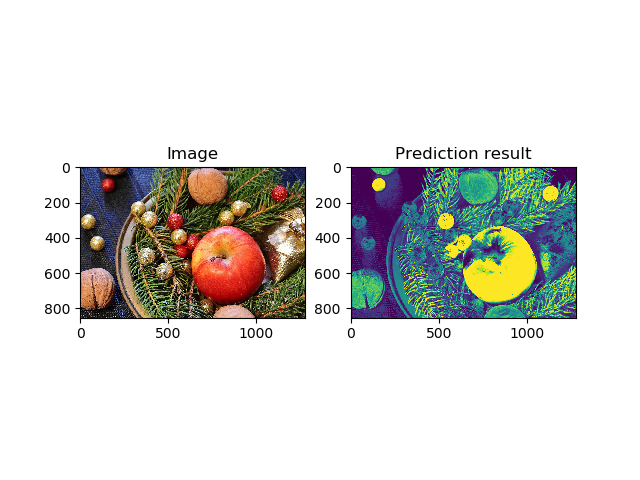

<IPython.core.display.Javascript object>


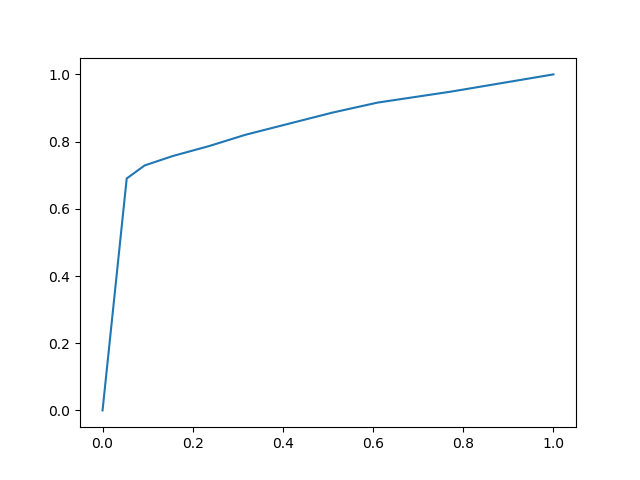

In [322]:
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Mytest[0])
ax1.set_title('Image')
ax2.imshow(mypostAlist[0])
ax2.set_title('Prediction result')
plt.figure()
plt.plot(FPR_M0,TPR_M0 )

In [324]:
# Find the best threshold so as the get the true positive rate and the true negative rate
distance0 = (FPR_M0 - 0)**2 + (TPR_M0 - 1)**2
min_distance0 = np.min(distance0)
# return the index that make the distance minimum
BestT0 = np.where(distance0 == min_distance0)
Best_threshold0 = 0.1 * (BestT0[0][0]-1)
print('The Best threshold is :',Best_threshold0)
TNR0 = 1 - FPR_M0[BestT0[0]]
print('The true negative rate under this threhold is ',TNR0)
print('The true positive rate under this threhold is ',TPR_M0[BestT[0]])

The Best threshold is : 0.7000000000000001
The true negative rate under this threhold is  [0.90664152]
The true positive rate under this threhold is  [0.88637088]


<IPython.core.display.Javascript object>


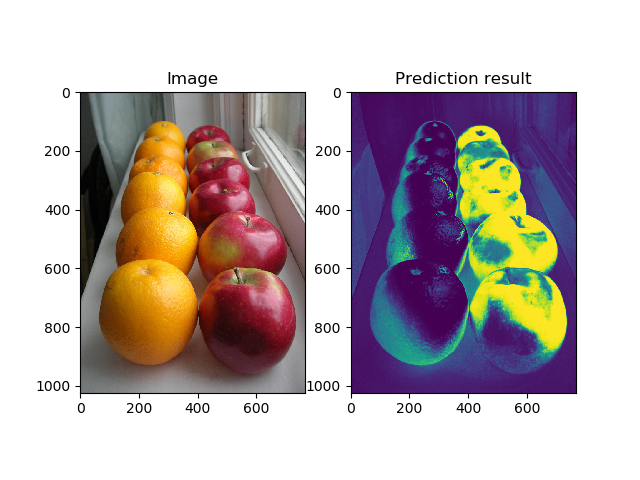

<IPython.core.display.Javascript object>


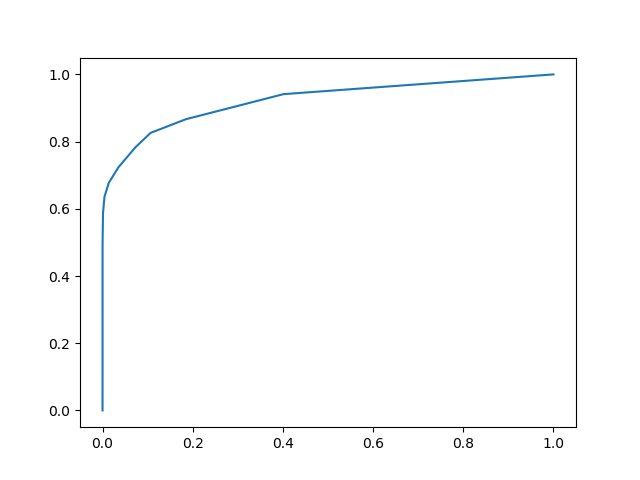

In [321]:
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Mytest[1])
ax1.set_title('Image')
ax2.imshow(mypostAlist[1])
ax2.set_title('Prediction result')
plt.figure()
plt.plot(FPR_M1,TPR_M1 )

In [323]:
# Find the best threshold so as the get the true positive rate and the true negative rate
distance1 = (FPR_M1 - 0)**2 + (TPR_M1 - 1)**2
min_distance1 = np.min(distance1)
# return the index that make the distance minimum
BestT1 = np.where(distance1 == min_distance1)
Best_threshold1 = 0.1 * (BestT1[0][0]-1)
print('The Best threshold is :',Best_threshold1)
TNR1 = 1 - FPR_M1[BestT[0]]
print('The true negative rate under this threhold is ',TNR1)
print('The true positive rate under this threhold is ',TPR_M1[BestT[0]])

The Best threshold is : 0.2
The true negative rate under this threhold is  [0.89352206]
The true positive rate under this threhold is  [0.82588892]


#  Important Results Comments:
Here are several reasons for the flaw and a few points that have to be clarified:

1. The trainning data set for both apple and Non apple are downsampleed for higher efficiency.This means the model we trained has stochastic property. If the random trainning set for apple unluckily to has a higher weight of one kind of apple, or did not include enough dark pixles, we may have poor result! one way to improve this is using random forest to train a few MOG model.

2. The background is too complex ( too many color like the first image I found )so three gaussian model is not enough to fit this case. 

#  The discussion of training set,validation set and test set.
Training set is the data set used to train the parameters of our gaussian model. We usually fit our model to the training set.In the training set, each single data will know its label(ground truth).Our training sets are RGB of a pixel, which are a three dimension data set.

Validation set is used when we do model selection.People use validation set to adjust the hyperparameter of our trained model.Validation set is extremely useful in K-fold cross validation because cross validation is a good way to cancel out the stochastic of model adn get better performance without having enough training data.Meanwhile, Cross Validation can decrease the overfitting situation.

Test set is used to evaluate the performance of the trained model at the very last. Usually ROC curve is an important reference.Test set data should never be used during traning phase.

Having these three sets we can optimize out model and understand the performance of our model. In general , more training data lead to more accurate result,  but will also result in longer training time. Meanwhile, If we have insufficient training data, we should use K-fold cross validation to improve our model.

Reference:
wiki pedia,available from:
https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets

# Extra!!!!!!
## Question 1: HSV  color space and imageing enhancing

Generally, The light intensity is not the only problem when doing machine learning . The saturation of the image also matter especially for those taskes that highly rely on RGB channel.One good way is to use HSV color space,because the second element term in HSV vector includes the satuaration information and the last term including the  light intensity information.

Therefore , we can increase the saturation and light intensity to make the color more 'vivid'by converting image from RGB color space to HSV  color space, slightly increasing S and V and then converting it back  .Aftering the color  enhancing, red becomes more 'red ' and green become more 'green'.The whole image will be more colorfull and that would be easier for Machine to learn.

In [311]:
# Converting the RGB pixel into HSV  color space
# IMPORTANT!!!!!  Have to use the same training set as the previous trained model
HSVapple = np.zeros([3,10000])
HSVNonapple = np.zeros([3,10000])
for ndata in range(10000):
    HSVapple[:,ndata] = colorsys.rgb_to_hsv(RGBApple[0,ndata]/255,RGBApple[1,ndata]/255,RGBApple[2,ndata]/255)
    HSVNonapple[:,ndata] = colorsys.rgb_to_hsv(RGBNonApple[0,ndata]/255,RGBNonApple[1,ndata]/255,RGBNonApple[2,ndata]/255)
    
# Color enhancing by increasing the saturation 
HSVapple[1,:] +=0.1
HSVNonapple[1,:]+=0.1

ERGBA = np.zeros([3,10000])
ERGBN = np.zeros([3,10000])

for ndata in range(10000):
    ERGBA[:,ndata] = colorsys.hsv_to_rgb(HSVapple[0,ndata],HSVapple[1,ndata],HSVapple[2,ndata])
    ERGBN[:,ndata] = colorsys.hsv_to_rgb(HSVNonapple[0,ndata],HSVNonapple[1,ndata],HSVNonapple[2,ndata])


In [314]:
# Number of Gaussian used to generate the MOG.According to our previous knowledge, 
# apple can be basically divided into two groups:Red apple and Green apple.So the MOG of should contain two gaussian component.
# one refers to red apple group and the other refer to green apple group.
CGauss =2
start_time = time.time()
# fit Gaussian model for apple data 
print('start to train the apple using normalized RGB')

# for Python training data set
mixGaussApple_E = fitMixGauss(ERGBA,CGauss)

print('mixGaussApple',mixGaussApple_E)

#fit Gaussian model for non-apple data
print('start to train the nonapple using normalized RGB')
# for Python training data set
# So used 3 gaussian component.
mixGaussNonApple_E = fitMixGauss(ERGBN,CGauss + 1 )

print('mixGaussNonApple',mixGaussNonApple_E)

elapsed =  time.time()-start_time
print('The whole trainning phase takes',elapsed,'seconds')

start to train the apple using normalized RGB
Log Likelihood Iter 0 : -44747.559

Training the data...Entering the iteration
Log Likelihood After Iter 0 : 4935.738

Log Likelihood After Iter 1 : 4949.065

Log Likelihood After Iter 2 : 4980.544

Log Likelihood After Iter 3 : 5057.509

Log Likelihood After Iter 4 : 5244.335

Log Likelihood After Iter 5 : 5663.948

Log Likelihood After Iter 6 : 6377.937

Log Likelihood After Iter 7 : 7208.860

Log Likelihood After Iter 8 : 8269.924

Log Likelihood After Iter 9 : 9450.169

Log Likelihood After Iter 10 : 10111.080

Log Likelihood After Iter 11 : 10339.594

Log Likelihood After Iter 12 : 10473.814

Log Likelihood After Iter 13 : 10619.196

Log Likelihood After Iter 14 : 10805.427

Log Likelihood After Iter 15 : 10993.234

Log Likelihood After Iter 16 : 11137.226

Log Likelihood After Iter 17 : 11236.870

Log Likelihood After Iter 18 : 11300.437

Log Likelihood After Iter 19 : 11332.151

Log Likelihood After Iter 20 : 11344.439

Log Likelihoo

In [317]:
priorA = cApple/(cNonapple + cApple)
priorNonA = cNonapple/(cNonapple + cApple)

# now run through the pixels in the image and classify them as being apple or
# non apple
im = Mytest[1]
postE,postNonE = Getposterior(im,mixGaussApple_E,mixGaussNormNonApple)
postOrigin,postNonOrigin = Getposterior(im,mixGaussApple,mixGaussNonApple)


(1024, 768, 3)
(1024, 768, 3)


In [1]:
plt.figure()
plt.imshow(Mytest[1])
plt.title('The raw image')

f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(postE)
ax1.set_title('The classification  result after imaging enhancing')
ax2.imshow(postOrigin)
ax2.set_title('The original classification result')

NameError: name 'plt' is not defined

# Comment:
As we can see from the above results, aftering applying imaging enhancing, some shadow part, or dark color part in the apple previous can be detected by our new model now.This is a big progress because the models now are less likely to be influenced by the brightness change.

# Hard to use Gabor Filter So this question is skipped

# Alternate Model
If asked to choose an alternate model to do the same task, I would select Support Vector Machine(SVM).SVM is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples[1].Unlike the MOG which needs us to choose a reasonable threshold for the probability, the model return by SVM is already a groups of parameter that can distinguish the binary samples.Also, SVM is easy to be implemented.

However, MOG performs better when the same category has different property(Like green apple to red apple) because it uses more than 2 gaussian to generate one model  which means it can cluster severl groups of sample data from the same category

reference:[1] Savan Patel ,  Chapter 2 : SVM (Support Vector Machine) — Theory, 2017.6 , available from :
https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72